In [45]:
import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [46]:
tr = pd.read_csv('../Downloads/input/X_train.csv')
target = pd.read_csv('../Downloads/input/y_train.csv')

In [47]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [48]:
tr.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [49]:
tr.shape

(487680, 13)

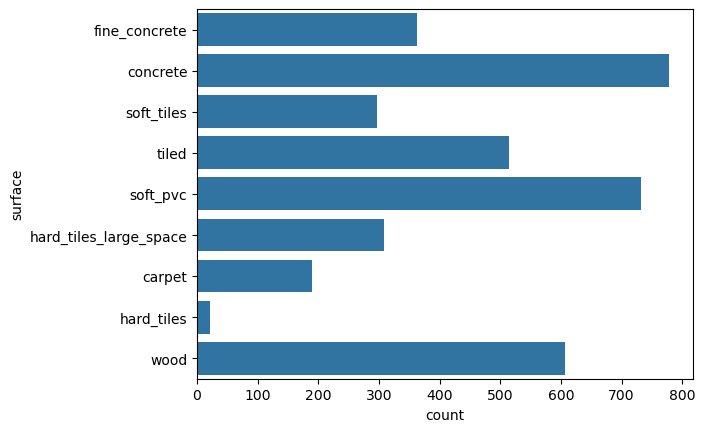

In [50]:
countplot(y = 'surface', data = target)
plt.show()

In [51]:
len(tr.measurement_number.value_counts())

128

In [52]:
tr.shape[0] / 128

3810.0

In [53]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5

    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']

    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)

    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz

    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']

    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

    def f2(x):
        return np.mean(np.abs(np.diff(x)))

    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']

        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)

        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)

        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [54]:
%%time
tr = fe(tr)

/tmp/ipykernel_3910/3437122433.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[col + '_min'] = actual.groupby(['series_id'])[col].min()
/tmp/ipykernel_3910/3437122433.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[col + '_max'] = actual.groupby(['series_id'])[col].max()
/tmp/ipykernel_3910/3437122433.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

CPU times: user 17.2 s, sys: 51.9 ms, total: 17.2 s
Wall time: 17.2 s


/tmp/ipykernel_3910/3437122433.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))


In [55]:
tr.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,...,8090.592033,2.278501e+06,6.255962e+05,9.597909e+06,1.409996e+06,15.342019,1.198969e+06,8924.000999,9.597909e+06,6.255962e+05
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,...,2339.913394,4.613413e+05,1.377975e+05,1.957088e+06,2.979271e+05,14.202636,2.049951e+05,569.164381,1.957088e+06,1.377975e+05
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,...,22485.416514,5.372327e+06,1.674839e+06,2.866679e+07,3.802655e+06,17.116144,2.355426e+06,-9135.272306,2.866679e+07,1.674839e+06
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.000026,-6.349206e-07,0.93968,0.93884,0.310140,...,2157.840573,4.765087e+05,8.652378e+04,3.121275e+06,4.627398e+05,36.074189,2.981020e+05,17412.401283,3.121275e+06,8.652378e+04
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.000080,7.936508e-08,0.89689,0.88673,0.428144,...,4804.885067,3.694817e+05,2.330043e+05,6.165090e+05,9.199986e+04,2.645912,2.281891e+04,-70.793166,6.165090e+05,2.330043e+05


In [56]:
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

In [57]:
target.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


In [58]:
tr.fillna(0, inplace = True)

In [59]:
tr.replace(-np.inf, 0, inplace = True)
tr.replace(np.inf, 0, inplace = True)

-------------------- 0 --------------------
score  0.8910761154855643


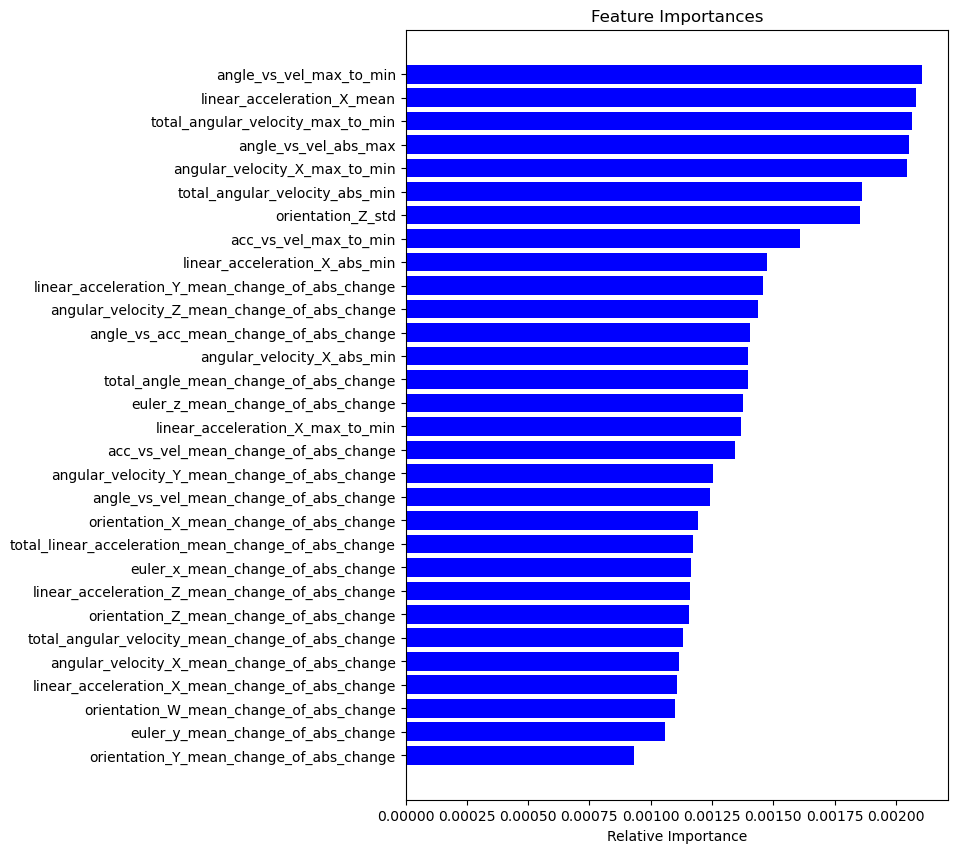

-------------------- 1 --------------------
score  0.9186351706036745


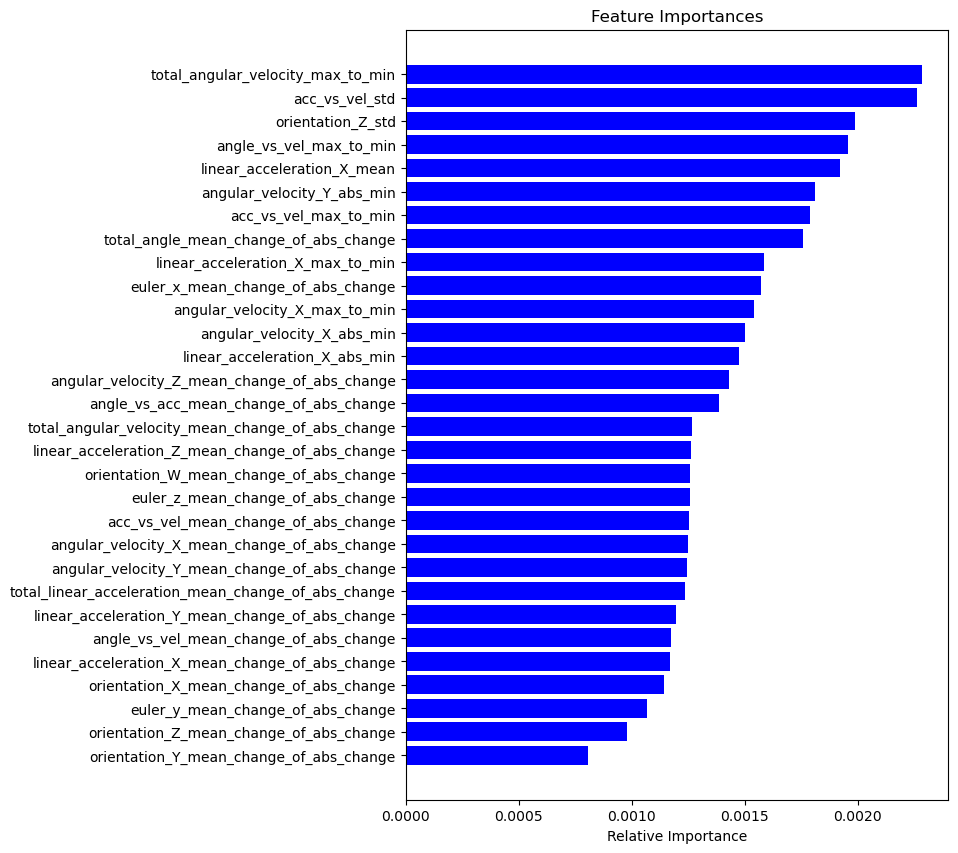

-------------------- 2 --------------------
score  0.905511811023622


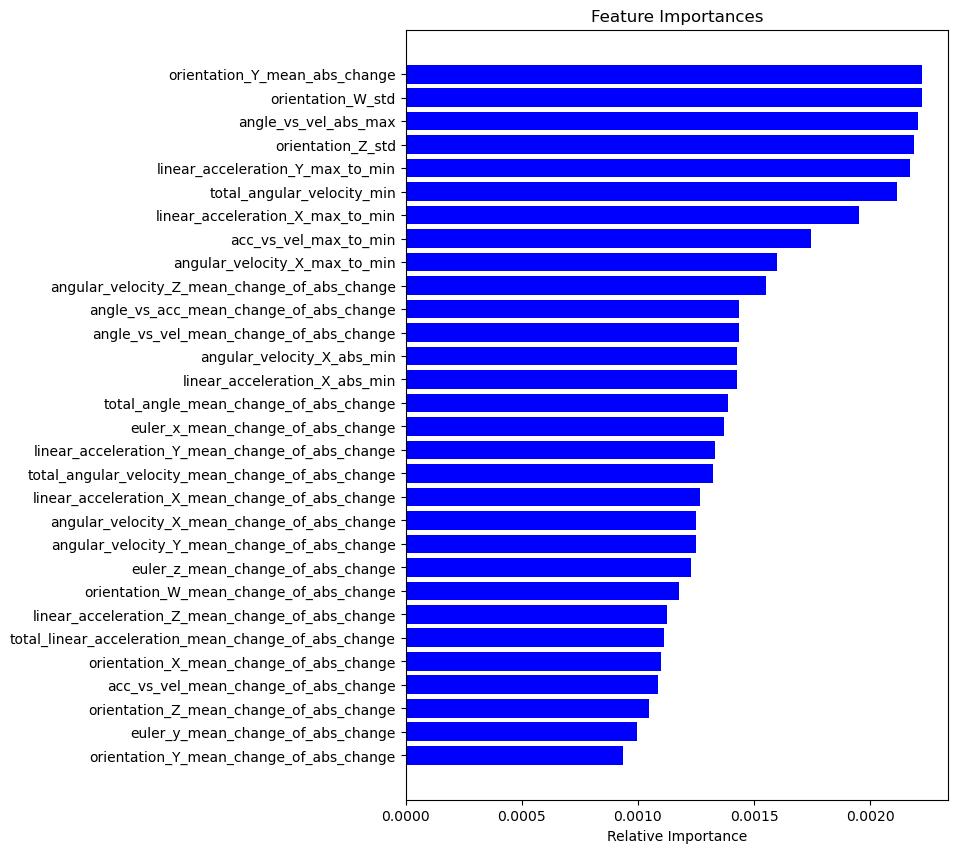

-------------------- 3 --------------------
score  0.8818897637795275


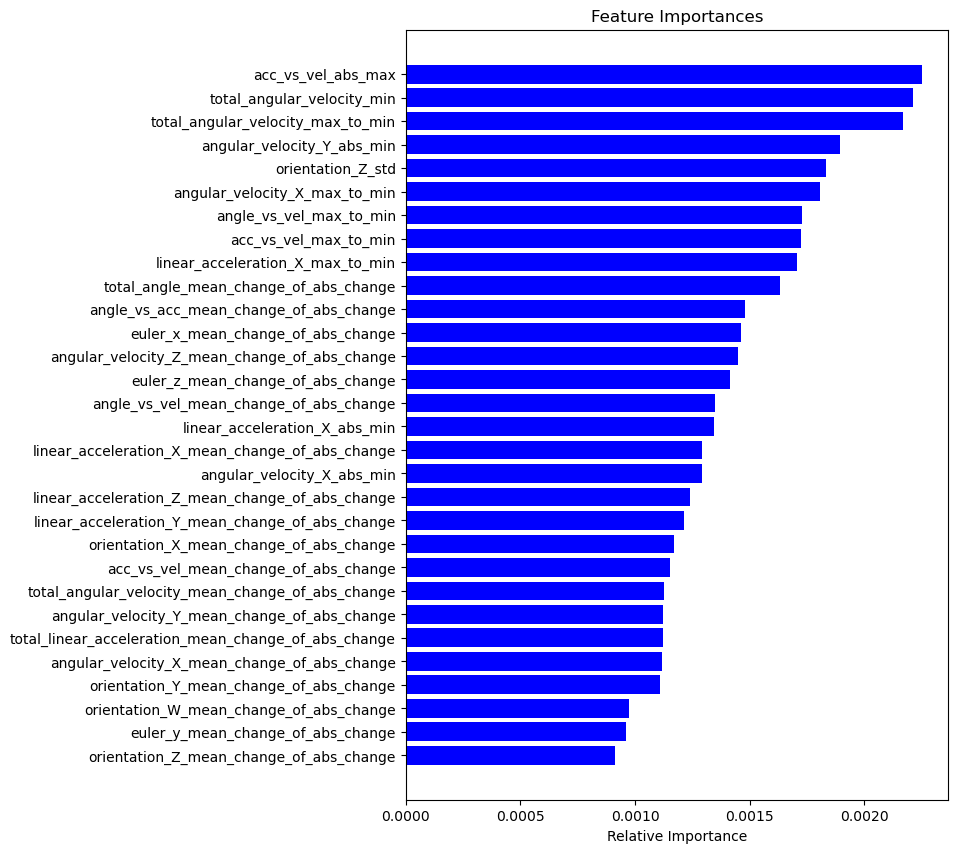

-------------------- 4 --------------------
score  0.9173228346456693


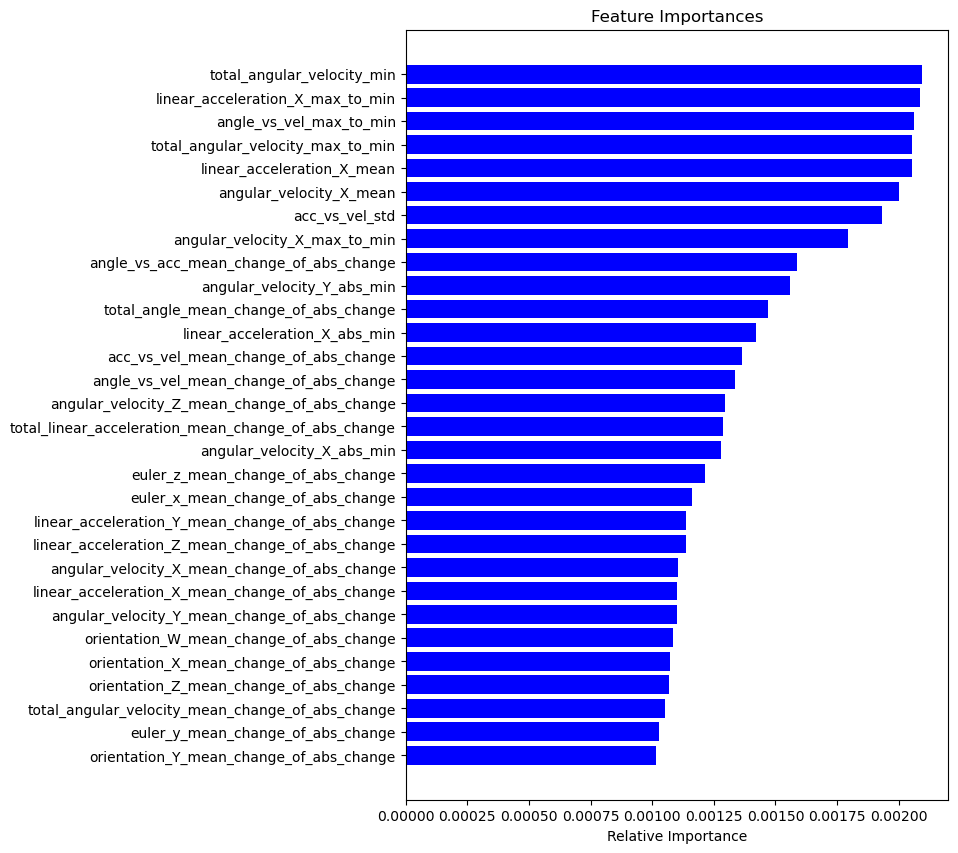

Avg Accuracy 0.9028871391076116


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds_rf = np.zeros((tr.shape[0]))
score = 0
for i, (train_index, test_index) in enumerate(folds.split(tr, target['surface'])):
    print('-'*20, i, '-'*20)
    
    clf =  RandomForestClassifier(n_estimators = 200, n_jobs = -1)
    # Build a forest of trees from the training set (X, y).
    clf.fit(tr.iloc[train_index], target['surface'][train_index])
    # The predicted class of an input sample is a vote by the trees in the forest, weighted by their probability estimates.
    oof_preds_rf[test_index] = clf.predict(tr.iloc[test_index])
    # Return the mean accuracy on the given test data and labels.
    score += clf.score(tr.iloc[test_index], target['surface'][test_index])
    print('score ', clf.score(tr.iloc[test_index], target['surface'][test_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = tr.columns

    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices[:hm]])
    plt.xlabel('Relative Importance')
    plt.show()

print('Avg Accuracy', score / folds.n_splits)

In [61]:
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = cm / 5.0  # Divide all values by 5
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

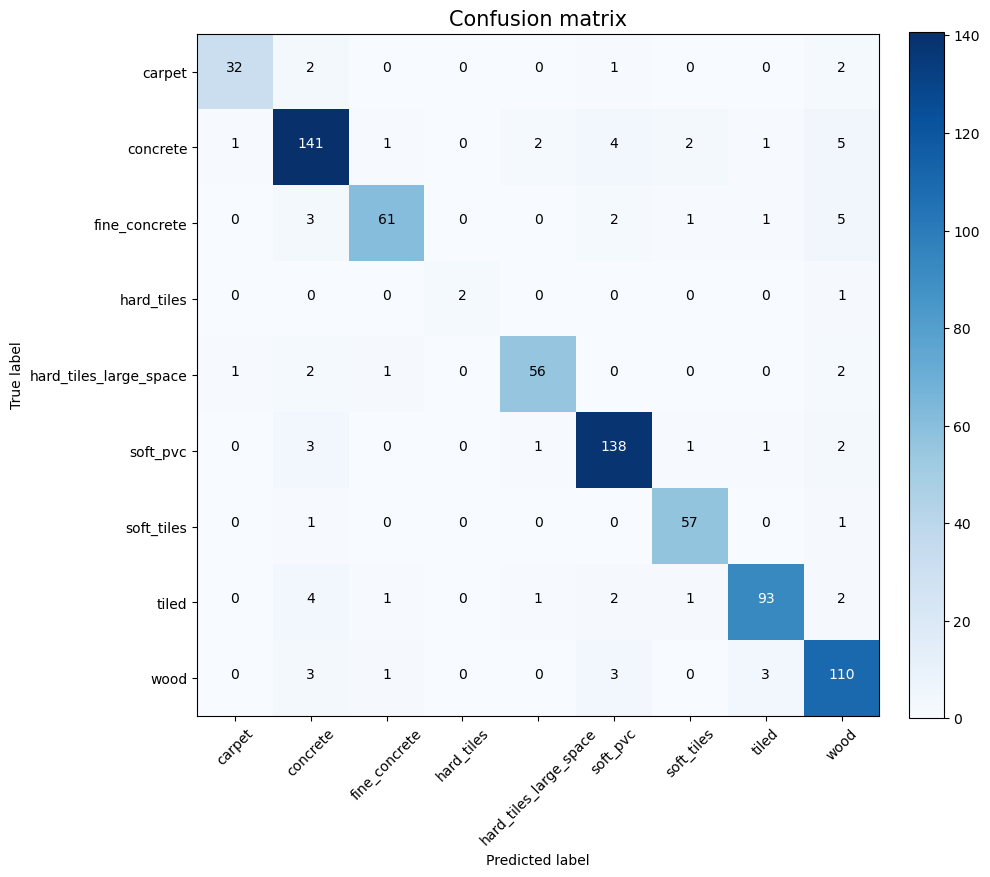

In [62]:
plot_confusion_matrix(target['surface'], oof_preds_rf, le.classes_)